In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier




In [2]:

# 1. Carga del dataset
# Asegúrate de que el archivo 'creditcard.csv' esté en la misma carpeta
df = pd.read_csv('creditcard.csv')

# 2. Validación de Integridad
print("--- VALIDACIÓN DE DATOS ---")
print(f"1. Total de registros: {df.shape[0]}")
print(f"2. Total de columnas: {df.shape[1]}")
print(f"3. ¿Hay valores nulos?: {df.isnull().sum().sum()}")
print(f"4. ¿Hay registros duplicados?: {df.duplicated().sum()}")

# 3. Tipos de datos
# Es vital saber si el dinero ('Amount') o el tiempo ('Time') son números reales
print("\n--- TIPOS DE DATOS ---")
print(df[['Time', 'Amount', 'Class']].dtypes)

--- VALIDACIÓN DE DATOS ---
1. Total de registros: 284807
2. Total de columnas: 31
3. ¿Hay valores nulos?: 0
4. ¿Hay registros duplicados?: 1081

--- TIPOS DE DATOS ---
Time      float64
Amount    float64
Class       int64
dtype: object


In [3]:
# Cálculo del desbalance 
conteo = df['Class'].value_counts(normalize=True) * 100
print(f"\n--- DISTRIBUCIÓN DEL FRAUDE ---")
print(f"Transacciones Normales (0): {conteo[0]:.2f}%")
print(f"Transacciones Fraude (1): {conteo[1]:.2f}%")


--- DISTRIBUCIÓN DEL FRAUDE ---
Transacciones Normales (0): 99.83%
Transacciones Fraude (1): 0.17%


In [4]:
dperdido=df[df['Class'] == 1]['Amount'].sum()
dperdido

np.float64(60127.97)

In [5]:

# 1. Eliminamos duplicados como sugeriste
df.drop_duplicates(inplace=True)

# 2. Inicializamos el escalador
rob_scaler = RobustScaler()

# 3. Escalamos 'Amount' y 'Time' (las únicas que no lo están)
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# 4. Quitamos las columnas originales para no confundir al modelo
df.drop(['Time','Amount'], axis=1, inplace=True)

# 5. Reorganizamos para tener las escaladas al principio (por orden)
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

print("Datos escalados y listos. Primeras 5 filas:")
print(df.head())

Datos escalados y listos. Primeras 5 filas:
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.774718    -0.995290 -1.359807 -0.072781  2.536347  1.378155   
1      -0.268530    -0.995290  1.191857  0.266151  0.166480  0.448154   
2       4.959811    -0.995279 -1.358354 -1.340163  1.773209  0.379780   
3       1.411487    -0.995279 -0.966272 -0.185226  1.792993 -0.863291   
4       0.667362    -0.995267 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25     

In [6]:
# 1. Barajamos los datos antes de recortar
df = df.sample(frac=1)

# 2. Separamos fraude y normales
fraude_df = df.loc[df['Class'] == 1]
normal_df = df.loc[df['Class'] == 0][:473] # Tomamos solo 473 normales

# 3. Concatenamos para crear el dataset equilibrado
normal_dist_df = pd.concat([fraude_df, normal_df])

# 4. Volvemos a barajar para que el modelo no aprenda el orden
new_df = normal_dist_df.sample(frac=1, random_state=42)

print(f"Nuevo dataset equilibrado: {new_df.shape}")
print(new_df['Class'].value_counts())

Nuevo dataset equilibrado: (946, 31)
Class
1    473
0    473
Name: count, dtype: int64


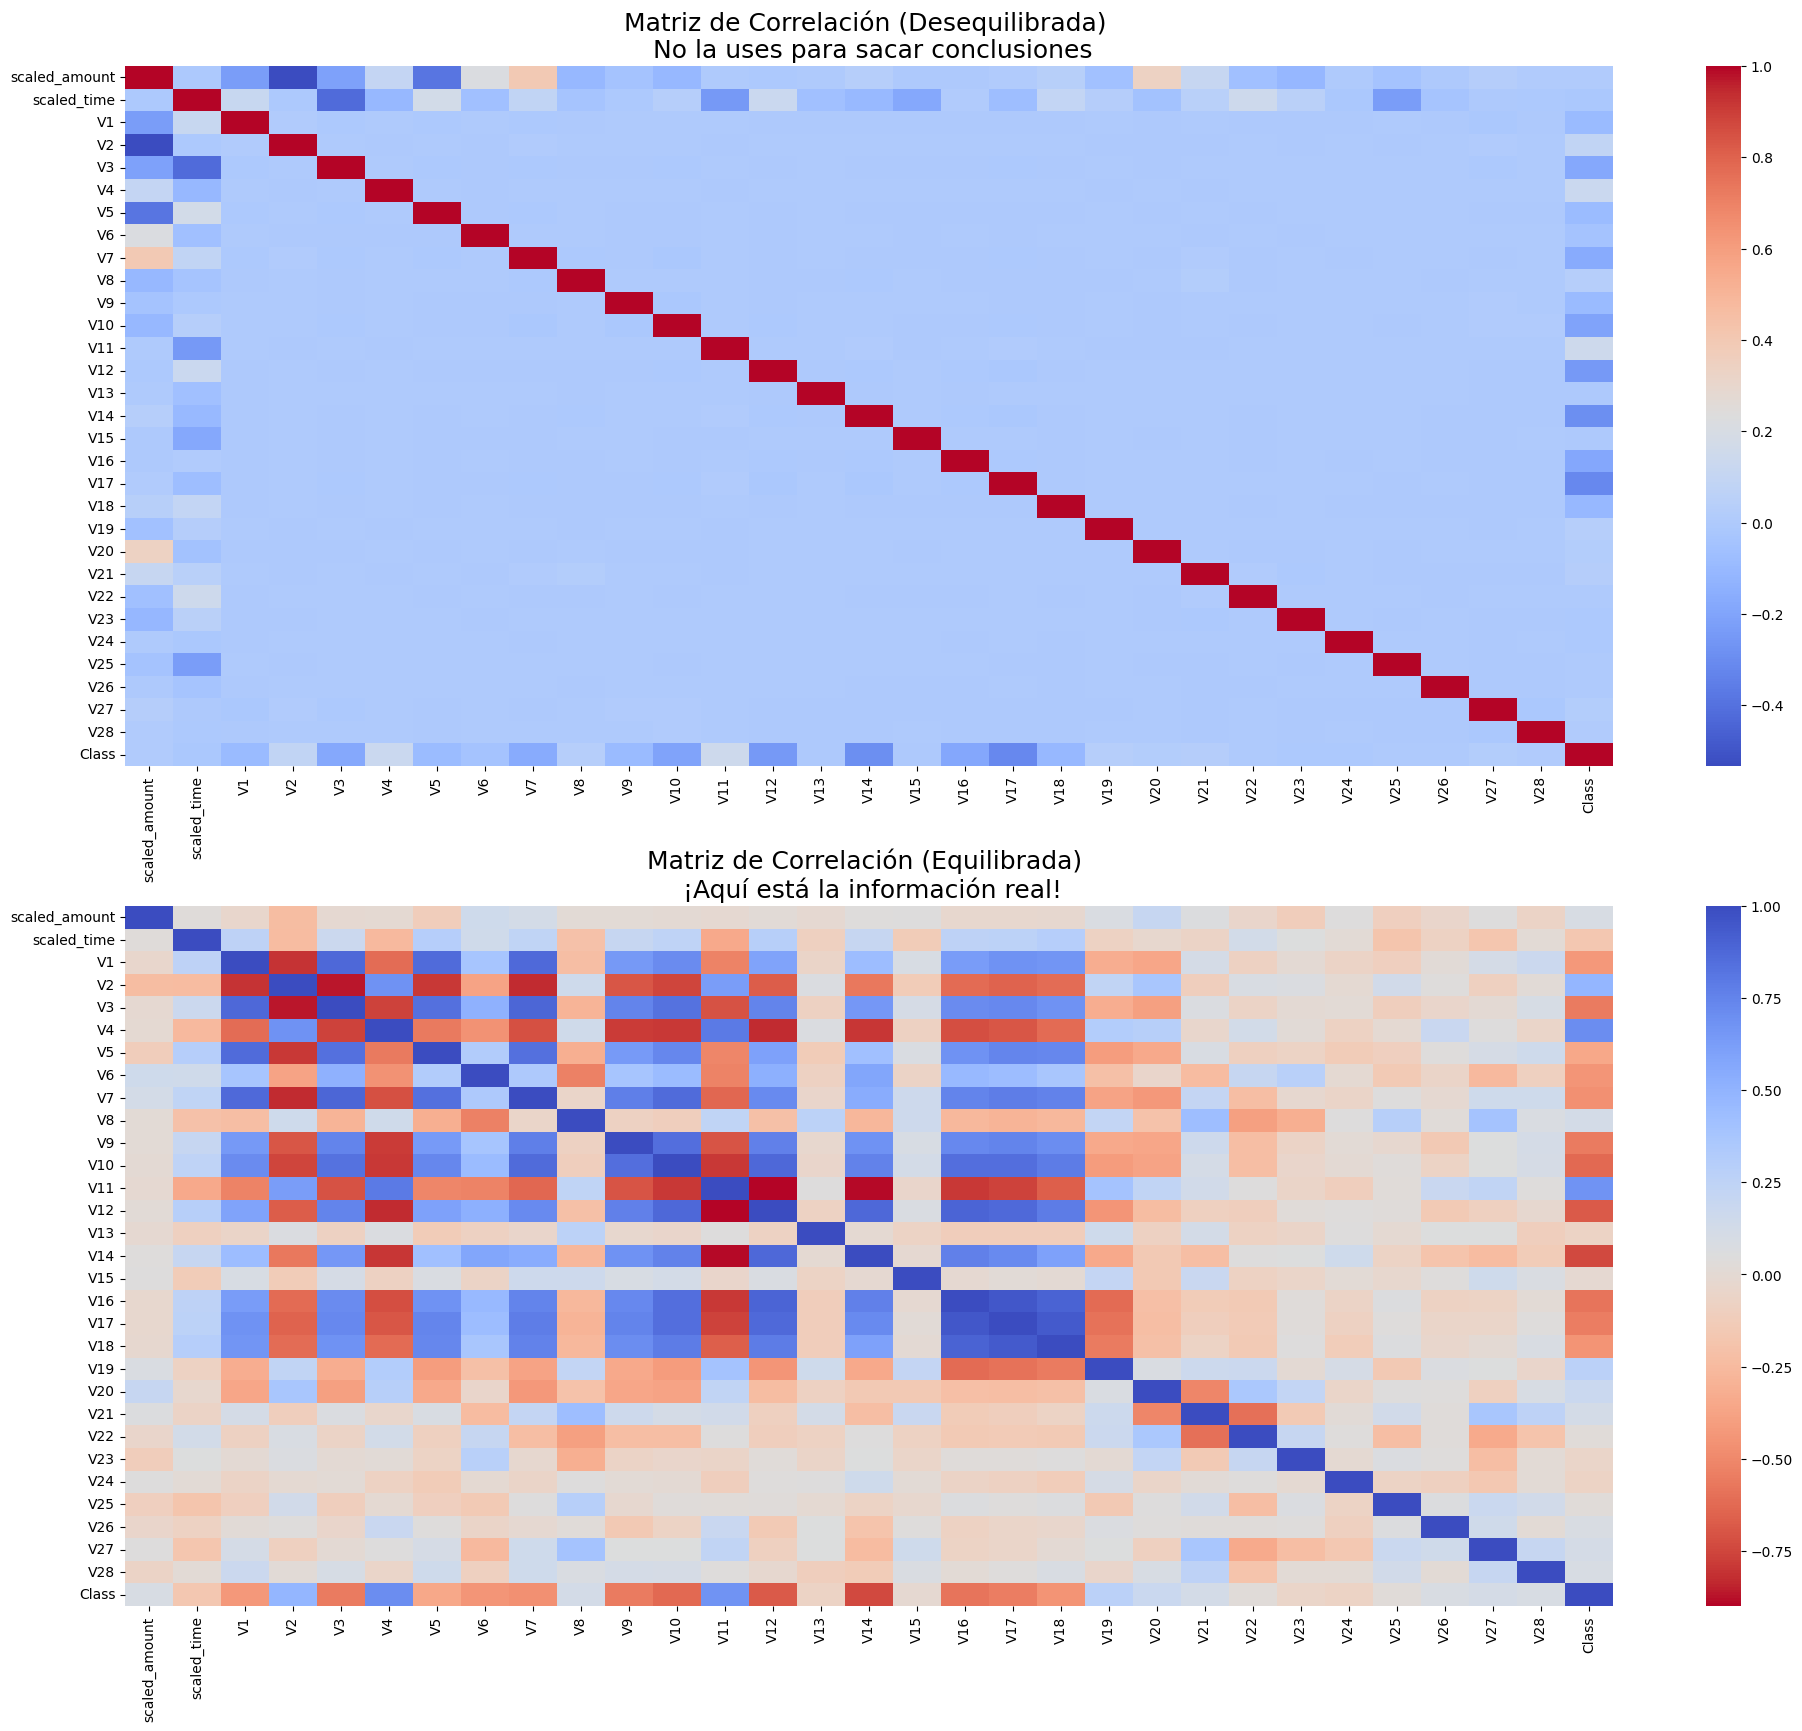

In [7]:

# Configuramos el lienzo
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# 1. Matriz de Correlación - Dataset Original (Desequilibrado)
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Matriz de Correlación (Desequilibrada) \n No la uses para sacar conclusiones", fontsize=18)

# 2. Matriz de Correlación - Nuevo Dataset (Equilibrado)
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Matriz de Correlación (Equilibrada) \n ¡Aquí está la información real!', fontsize=18)

plt.show()

In [8]:
#Vamos a mirar las correlaciones para ver cual tiene mas peso en el modelo
# # Ordenados de menor a mayor
print("Variables con mayor impacto negativo:")
print(new_df.corr()['Class'].sort_values(ascending=True).head(5))

print("\nVariables con mayor impacto positivo:")
print(new_df.corr()['Class'].sort_values(ascending=False).head(5))

Variables con mayor impacto negativo:
V14   -0.741484
V12   -0.679546
V10   -0.626179
V16   -0.582054
V9    -0.558587
Name: Class, dtype: float64

Variables con mayor impacto positivo:
Class    1.000000
V4       0.708102
V11      0.677296
V2       0.481723
V19      0.265871
Name: Class, dtype: float64


In [9]:
# Analizamos V14 (la que tiene correlación negativa más fuerte)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25

# Calculamos los límites (Corte de Tukey)
v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off

print(f"Límite inferior para V14: {v14_lower}")
print(f"Límite superior para V14: {v14_upper}")

# Eliminamos los outliers del dataset
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print(f'Outliers identificados en V14: {len(outliers)}')

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('---' * 10)
print(f'Registros restantes tras limpiar V14: {len(new_df)}')

Límite inferior para V14: -17.38415366616548
Límite superior para V14: 3.62654724179084
Outliers identificados en V14: 7
------------------------------
Registros restantes tras limpiar V14: 939


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# 1. Separamos las variables (X) de la etiqueta (y)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# 2. Dividimos el dataset (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenamos el modelo
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# 4. Hacemos las predicciones
y_pred = log_reg.predict(X_test)

print("¡Modelo entrenado y predicciones generadas!")

¡Modelo entrenado y predicciones generadas!


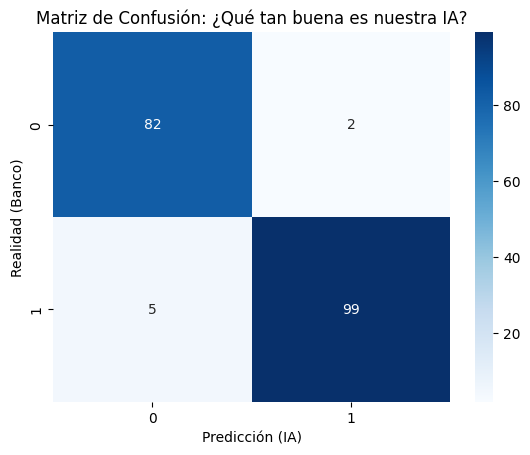

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        84
           1       0.98      0.95      0.97       104

    accuracy                           0.96       188
   macro avg       0.96      0.96      0.96       188
weighted avg       0.96      0.96      0.96       188



In [11]:
# Visualizamos la Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción (IA)')
plt.ylabel('Realidad (Banco)')
plt.title('Matriz de Confusión: ¿Qué tan buena es nuestra IA?')
plt.show()

# Resumen de métricas
print(classification_report(y_test, y_pred))

In [12]:
#%pip install imbalanced-learn


In [13]:
# 1. Usamos el dataset ORIGINAL 
X = df.drop('Class', axis=1)
y = df['Class']

# 2. División Crítica: Mantenemos el test con datos reales y desbalanceados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Aplicamos SMOTE solo al entrenamiento
print(f"Antes de SMOTE: {sum(y_train==1)} fraudes")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Después de SMOTE: {sum(y_train_res==1)} fraudes (¡Equilibrado!)")

# 4. Entrenamos la misma Regresión Logística
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_res, y_train_res)

# 5. Predicción sobre los datos reales de TEST
y_pred_smote = log_reg_smote.predict(X_test)



Antes de SMOTE: 374 fraudes


/Users/sebastiangutierrezf/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Después de SMOTE: 226606 fraudes (¡Equilibrado!)


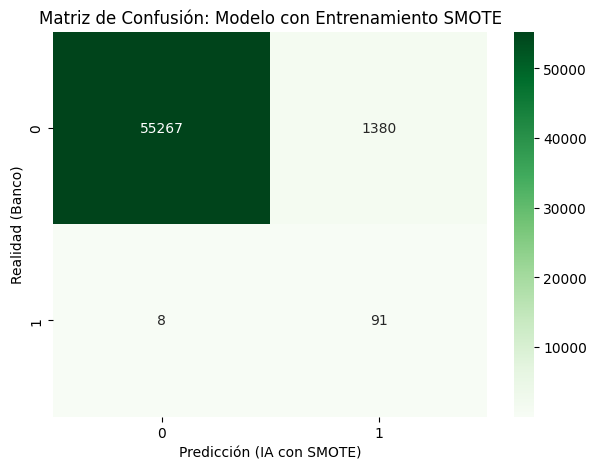

--- INFORME DE RENDIMIENTO (SMOTE) ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56647
           1       0.06      0.92      0.12        99

    accuracy                           0.98     56746
   macro avg       0.53      0.95      0.55     56746
weighted avg       1.00      0.98      0.99     56746



In [14]:

# 1. Generamos la matriz de confusión para las predicciones con SMOTE
cm_smote = confusion_matrix(y_test, y_pred_smote)

# 2. Visualización
plt.figure(figsize=(7,5))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', cbar=True)
plt.xlabel('Predicción (IA con SMOTE)')
plt.ylabel('Realidad (Banco)')
plt.title('Matriz de Confusión: Modelo con Entrenamiento SMOTE')
plt.show()

# 3. Informe detallado
print("--- INFORME DE RENDIMIENTO (SMOTE) ---")
print(classification_report(y_test, y_pred_smote))

Entrenando el Bosque Aleatorio... Esto puede tardar un poco más.

--- INFORME DE RENDIMIENTO: RANDOM FOREST + SMOTE ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56647
           1       0.91      0.85      0.88        99

    accuracy                           1.00     56746
   macro avg       0.96      0.92      0.94     56746
weighted avg       1.00      1.00      1.00     56746



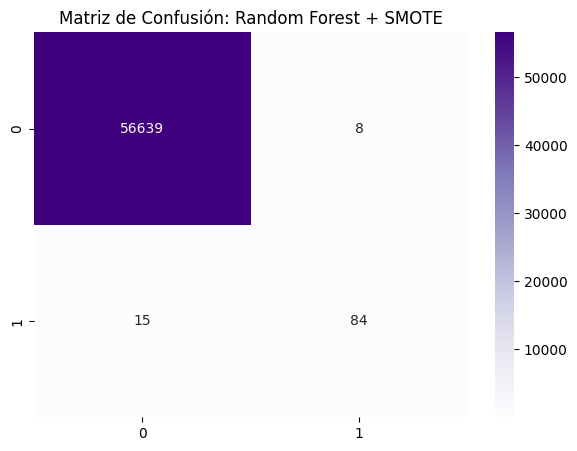

In [15]:

# 1. Inicializar el modelo (con 100 árboles para empezar)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Entrenar con los datos de SMOTE (los mismos que usamos antes)
print("Entrenando el Bosque Aleatorio... Esto puede tardar un poco más.")
rf_model.fit(X_train_res, y_train_res)

# 3. Predicciones
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluación
print("\n--- INFORME DE RENDIMIENTO: RANDOM FOREST + SMOTE ---")
print(classification_report(y_test, y_pred_rf))

# 5. Matriz de Confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(7,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples', cbar=True)
plt.title('Matriz de Confusión: Random Forest + SMOTE')
plt.show()